In [53]:
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import datetime

In [54]:
def create_temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add temporal features to the dataset, capturing short-term and long-term patterns.

    Features added:
    - 1-day lag value: captures immediate influence of the previous day's sales.
    - Cumulative sums for 7-day and 15-day windows: reflect weekly and bi-weekly consumption patterns.
    - Rolling means and standard deviations for 7-day and 15-day windows: track short-term and mid-term trends.
    - is_weekend: indicates if sales occurred on a weekend.
    - day_of_month: captures end-of-month or salary-related purchasing patterns.
    - is_holiday (if 'event_name_1' is available): identifies potential holiday-related sales spikes.

    Parameters:
    ----------
    df : pd.DataFrame
        DataFrame containing sales data with the following columns:
        - 'item_id': Item identifier.
        - 'store_id': Store identifier.
        - 'date': Sales date.
        - 'y': Sales value (target variable).

    Returns:
    --------
    pd.DataFrame
        DataFrame with new temporal feature columns added.
    """
    # Ensure the DataFrame is sorted for correct lag and rolling calculations
    df = df.sort_values(['item_id', 'store_id', 'date'])

    # Difference between current day and previous day
    df['delta_1'] = df.groupby(['item_id', 'store_id'], observed=False)['y'].diff(1)

    # Cumulative sum of the last 7, 15 and 30 days
    df['sum_7'] = sum(df.groupby(['item_id', 'store_id'], observed=False)['y'].shift(i) for i in range(1, 8))
    df['sum_15'] = sum(df.groupby(['item_id', 'store_id'], observed=False)['y'].shift(i) for i in range(1, 16))
    # df['sum_30'] = sum(df.groupby(['item_id', 'store_id'], observed=False)['y'].shift(i) for i in range(1, 31))
    
    # Rolling mean and standard deviation for 7-day and 15-day windows
    for window in [7, 15]:
        df[f'rolling_mean_{window}'] = (
            df.groupby(['item_id', 'store_id'], observed=False)['y']
              .rolling(window=window, min_periods=1).mean()
              .shift(1)
              .reset_index(level=[0, 1], drop=True)
        )
        df[f'rolling_std_{window}'] = (
            df.groupby(['item_id', 'store_id'], observed=False)['y']
              .rolling(window=window, min_periods=1).std()
              .shift(1)
              .reset_index(level=[0, 1], drop=True)
        )


    return df

In [55]:
def create_date_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add calendar-based features to the dataset.

    Features added:
    - Day of the week (categorical)
    - Month (categorical)
    - Event type (if available): identifies specific events or holidays that could impact sales.

    Parameters:
    ----------
    df : pd.DataFrame
        DataFrame containing a 'date' column.

    Returns:
    --------
    pd.DataFrame
        DataFrame with new date-based features.
    """
    # Day of the week (1 = Monday, 7 = Sunday)
    df['wday'] = df['date'].dt.dayofweek + 1
    df['wday'] = df['wday'].astype('category')

    # Month as a categorical variable
    df['month'] = df['date'].dt.month
    df['month'] = df['month'].astype('category')

    # # Indicates if the date falls on a weekend
    # df['is_weekend'] = (df['date'].dt.dayofweek >= 5).astype('category')

    # Day of the month: identifies end-of-month trends
    df['day_of_month'] = df['date'].dt.day


    # Event indicator: uses event_type_1 or assigns 'No_Event' if missing
    if 'event_type_1' in df.columns:
        # Remove temporariamente o tipo 'category' para preencher corretamente
        df['event_indicator'] = df['event_type_1'].astype(str).fillna('No_Event')
        
        # Substitui strings 'nan' que surgiram ao converter para string
        df['event_indicator'] = df['event_indicator'].replace('nan', 'No_Event')

        # Converte novamente para category com a categoria 'No_Event' incluída
        df['event_indicator'] = df['event_indicator'].astype('category')
    else:
        # Se a coluna não existir, cria a coluna com 'No_Event'
        df['event_indicator'] = pd.Series(['No_Event'] * len(df), dtype='category')

    return df


In [56]:
def remove_unused_columns(df: pd.DataFrame, columns_to_drop: list) -> pd.DataFrame:
    return df.drop(columns=columns_to_drop, axis=1)


## Data Loading and Preparation

In [42]:
# Load training data
train_df = pd.read_parquet('../data/train.snap.parquet')
train_df

/opt/homebrew/Caskroom/miniforge/base/envs/shipbob-interview/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,id,item_id,dept_id,cat_id,store_id,state_id,d,y,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1542,1.0,2015-04-19,11512,nan,nan,nan,nan,0,0,0,2.240234
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1543,0.0,2015-04-20,11512,nan,nan,nan,nan,0,0,0,2.240234
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1544,0.0,2015-04-21,11512,nan,nan,nan,nan,0,0,0,2.240234
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1545,0.0,2015-04-22,11512,nan,nan,nan,nan,0,0,0,2.240234
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1546,1.0,2015-04-23,11512,nan,nan,nan,nan,0,0,0,2.240234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12159127,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1937,0.0,2016-05-18,11616,nan,nan,nan,nan,0,0,0,5.941406
12159128,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1938,0.0,2016-05-19,11616,nan,nan,nan,nan,0,0,0,5.941406
12159129,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1939,0.0,2016-05-20,11616,nan,nan,nan,nan,0,0,0,5.941406
12159130,HOUSEHOLD_2_516_WI_3_evaluation,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,d_1940,0.0,2016-05-21,11617,nan,nan,nan,nan,0,0,0,5.941406


In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12159132 entries, 0 to 12159131
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             category      
 7   y             float16       
 8   date          datetime64[ns]
 9   wm_yr_wk      uint16        
 10  event_name_1  category      
 11  event_type_1  category      
 12  event_name_2  category      
 13  event_type_2  category      
 14  snap_CA       uint8         
 15  snap_TX       uint8         
 16  snap_WI       uint8         
 17  sell_price    float16       
dtypes: category(11), datetime64[ns](1), float16(2), uint16(1), uint8(3)
memory usage: 360.9 MB


In [44]:
print(train_df['event_type_1'].value_counts(dropna=False))
print(train_df['event_type_2'].value_counts(dropna=False))

event_type_1
nan          11186101
Religious      304462
National       304080
Cultural       273379
Sporting        91110
Name: count, dtype: int64
event_type_2
nan          12159132
Cultural            0
Religious           0
Name: count, dtype: int64


## Feature Engineering

In [45]:
# Apply functions to train_df dataset
train_df = create_date_features(train_df)

# Creating a consolidated snap column to reduce dimensionality
train_df['snap'] = train_df[['snap_CA', 'snap_TX', 'snap_WI']].max(axis=1).astype('category')

# Removing redundant columns after snap consolidation
columns_to_drop = ['id', 'dept_id', 'cat_id', 'state_id', 'wm_yr_wk', 
                   'event_type_1', 'event_name_1', 'event_type_2', 'event_name_2', 
                   'snap_CA', 'snap_TX', 'snap_WI', ]
train_df = remove_unused_columns(train_df, columns_to_drop)

train_df.head()

/opt/homebrew/Caskroom/miniforge/base/envs/shipbob-interview/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,item_id,store_id,d,y,date,sell_price,wday,month,day_of_month,event_indicator,snap
0,FOODS_1_001,CA_1,d_1542,1.0,2015-04-19,2.240234,7,4,19,No_Event,0
1,FOODS_1_001,CA_1,d_1543,0.0,2015-04-20,2.240234,1,4,20,No_Event,0
2,FOODS_1_001,CA_1,d_1544,0.0,2015-04-21,2.240234,2,4,21,No_Event,0
3,FOODS_1_001,CA_1,d_1545,0.0,2015-04-22,2.240234,3,4,22,No_Event,0
4,FOODS_1_001,CA_1,d_1546,1.0,2015-04-23,2.240234,4,4,23,No_Event,0


In [46]:
# Apply temporal metric calculations
train_df = create_temporal_features(train_df)

cutoff_date = train_df['date'].min() + datetime.timedelta(days=30)
train_df = train_df[train_df['date'] > cutoff_date]


# Display the first rows to verify changes
train_df.head()

/opt/homebrew/Caskroom/miniforge/base/envs/shipbob-interview/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,item_id,store_id,d,y,date,sell_price,wday,month,day_of_month,event_indicator,snap,delta_1,sum_7,sum_15,rolling_mean_7,rolling_std_7,rolling_mean_15,rolling_std_15
5718316,HOBBIES_1_001,CA_1,d_1573,0.0,2015-05-20,8.257812,3,5,20,No_Event,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5718317,HOBBIES_1_001,CA_1,d_1574,0.0,2015-05-21,8.257812,4,5,21,No_Event,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5718318,HOBBIES_1_001,CA_1,d_1575,0.0,2015-05-22,8.257812,5,5,22,No_Event,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5718319,HOBBIES_1_001,CA_1,d_1576,0.0,2015-05-23,8.257812,6,5,23,No_Event,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5718320,HOBBIES_1_001,CA_1,d_1577,0.0,2015-05-24,8.257812,7,5,24,No_Event,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11226877 entries, 5718316 to 5718284
Data columns (total 18 columns):
 #   Column           Dtype         
---  ------           -----         
 0   item_id          category      
 1   store_id         category      
 2   d                category      
 3   y                float16       
 4   date             datetime64[ns]
 5   sell_price       float16       
 6   wday             category      
 7   month            category      
 8   day_of_month     int32         
 9   event_indicator  category      
 10  snap             category      
 11  delta_1          float16       
 12  sum_7            float16       
 13  sum_15           float16       
 14  rolling_mean_7   float64       
 15  rolling_std_7    float64       
 16  rolling_mean_15  float64       
 17  rolling_std_15   float64       
dtypes: category(7), datetime64[ns](1), float16(5), float64(4), int32(1)
memory usage: 760.3 MB


## Training

### Split the dataset into training and validation sets 

| Dataset                      | Date Range                  | Purpose         |
|------------------------------|-----------------------------|-----------------|
| sales_train_validation.csv   | 2011-01-29 to 2016-04-24     | Training data   |
| sales_test_validation.csv    | 2016-04-25 to 2016-05-22     | Validation data |
| sales_test_evaluation.csv    | 2016-05-23 to 2016-06-19     | Test data       |


In [55]:
# Define the cutoff date for train-validation split
cutoff_date = '2016-04-25'

# Create copies to avoid modifying the original DataFrame
validation_data = train_df.query("date >= @cutoff_date").copy().reset_index(drop=True)
train_df = train_df.query("date < @cutoff_date").copy().reset_index(drop=True)

# Select features and target variable
features = [
    'item_id', 'store_id', 'wday', 'month', 'day_of_month', 'event_indicator', 'snap', 'sell_price',
    'delta_1', 'sum_7', 'sum_15', 
    'rolling_mean_7', 'rolling_std_7', 'rolling_mean_15', 'rolling_std_15'
]
# 'sum_30', 

# Create feature matrices and target vectors
X_train, y_train = train_df[features], train_df['y']
X_val, y_val = validation_data[features], validation_data['y']

In [56]:
print(train_df['date'].max(), validation_data['date'].min())
print(validation_data.shape, train_df.shape)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

2016-04-24 00:00:00 2016-04-25 00:00:00
(853720, 18) (10373157, 18)
(10373157, 15) (10373157,)
(853720, 15) (853720,)


### Model Training


- **`enable_categorical=True`**: Simplifies data processing and improves model handling of categorical features.  
- **`early_stopping_rounds=10`**: Provides a balanced patience window to avoid unnecessary training.  
- **`min_child_weight=5`**: Reduces complexity by preventing splits on small data subsets, promoting generalization.  

In [57]:
model = xgb.XGBRegressor(
    enable_categorical=True,
    early_stopping_rounds=10,
    min_child_weight=5,
    random_state=33
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

[0]	validation_0-rmse:2.76666
[1]	validation_0-rmse:2.20519
[2]	validation_0-rmse:1.85480
[3]	validation_0-rmse:1.64529
[4]	validation_0-rmse:1.52776
[5]	validation_0-rmse:1.45638
[6]	validation_0-rmse:1.41356
[7]	validation_0-rmse:1.38655
[8]	validation_0-rmse:1.37157
[9]	validation_0-rmse:1.36045
[10]	validation_0-rmse:1.34843
[11]	validation_0-rmse:1.34016
[12]	validation_0-rmse:1.33153
[13]	validation_0-rmse:1.32649
[14]	validation_0-rmse:1.32439
[15]	validation_0-rmse:1.32057
[16]	validation_0-rmse:1.31810
[17]	validation_0-rmse:1.31352
[18]	validation_0-rmse:1.31262
[19]	validation_0-rmse:1.31065
[20]	validation_0-rmse:1.30979
[21]	validation_0-rmse:1.30717
[22]	validation_0-rmse:1.30588
[23]	validation_0-rmse:1.30413
[24]	validation_0-rmse:1.30240
[25]	validation_0-rmse:1.30092
[26]	validation_0-rmse:1.30613
[27]	validation_0-rmse:1.30623
[28]	validation_0-rmse:1.30563
[29]	validation_0-rmse:1.30412
[30]	validation_0-rmse:1.30273
[31]	validation_0-rmse:1.30181
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=33, ...)

In [58]:
# Save the model
joblib.dump(model, '../models/xgb_model.pkl')

['../models/xgb_model.pkl']

In [59]:
# Predictions on the training set
y_pred_train = model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

print(f"MAE (train): {mae_train:.2f}")
print(f"RMSE (train): {rmse_train:.2f}")

# Predictions on the validation set
y_pred_val = model.predict(X_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print(f"MAE (validation): {mae_val:.2f}")
print(f"RMSE (validation): {rmse_val:.2f}")

MAE (train): 0.48
RMSE (train): 1.28
MAE (validation): 0.52
RMSE (validation): 1.29


**Comparison between MAE and RMSE:**
- **MAE:** Measures the average absolute error.  
- **RMSE:** Highlights large errors due to quadratic penalization.  

**Interpretation:**  
If the difference between **RMSE** and **MAE** is large, it indicates the presence of **outliers or significant prediction errors** that MAE does not emphasize.

## Test Set Predictions

In [102]:
# Load the data and the trained model
train_df = pd.read_parquet('../data/train.snap.parquet')
test_df = pd.read_parquet('../data/test.snap.parquet')
# test_df.info()
model = joblib.load('../models/xgb_model.pkl')

In [103]:
feature_names = model.get_booster().feature_names
print(feature_names)

print(train_df.info())
print(test_df.info())

['item_id', 'store_id', 'wday', 'month', 'day_of_month', 'event_indicator', 'snap', 'sell_price', 'delta_1', 'sum_7', 'sum_15', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_15', 'rolling_std_15']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12159132 entries, 0 to 12159131
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             category      
 7   y             float16       
 8   date          datetime64[ns]
 9   wm_yr_wk      uint16        
 10  event_name_1  category      
 11  event_type_1  category      
 12  event_name_2  category      
 13  event_type_2  category      
 14  snap_CA       uint8         
 15  snap_TX       uint8         
 16  snap_WI       uint8         
 17  sell_price    float16       
dtype

In [104]:
history_start_date = '2016-04-01'
df = pd.concat([train_df[train_df['date'] >= history_start_date], test_df])
df.reset_index(drop=True, inplace=True)


df = create_date_features(df)

df['snap'] = df[['snap_CA', 'snap_TX', 'snap_WI']].max(axis=1).astype('category')

# Removing redundant columns after snap consolidation
columns_to_drop = ['id', 'dept_id', 'cat_id', 'state_id', 'wm_yr_wk', 
                   'event_type_1', 'event_name_1', 'event_type_2', 'event_name_2', 
                   'snap_CA', 'snap_TX', 'snap_WI', ]
df = remove_unused_columns(df, columns_to_drop)


In [105]:
features = [
    'item_id', 'store_id', 'wday', 'month', 'day_of_month', 'event_indicator', 'snap', 'sell_price',
    'delta_1', 'sum_7', 'sum_15', 
    'rolling_mean_7', 'rolling_std_7', 'rolling_mean_15', 'rolling_std_15'
]

# Forecast for test days
prediction_days = [f'd_{day}' for day in range(1942, 1970)]

data = df.copy()
for d in prediction_days:
    current_date = data[data['d'] == d]['date'].iloc[0]
    window_start = current_date - pd.Timedelta(days=40)

    batch = data[(data['date'] > window_start) & (data['date'] <= current_date)]
    batch = create_temporal_features(batch)

    X_test = batch[batch['d'] == d][features]


    y_pred = model.predict(X_test)
    data.loc[X_test.index, 'y'] = y_pred

In [106]:
print(batch.info())
print(X_test.info())
test = test_df[['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'y']]
test

<class 'pandas.core.frame.DataFrame'>
Index: 1219600 entries, 747280 to 2439199
Data columns (total 18 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   item_id          1219600 non-null  category      
 1   store_id         1219600 non-null  category      
 2   d                1219600 non-null  category      
 3   y                1219600 non-null  float32       
 4   date             1219600 non-null  datetime64[ns]
 5   sell_price       1219600 non-null  float16       
 6   wday             1219600 non-null  category      
 7   month            1219600 non-null  category      
 8   day_of_month     1219600 non-null  int32         
 9   event_indicator  1219600 non-null  category      
 10  snap             1219600 non-null  category      
 11  delta_1          1189110 non-null  float32       
 12  sum_7            1006170 non-null  float32       
 13  sum_15           762250 non-null   float32       
 14  ro

,item_id,dept_id,cat_id,store_id,state_id,d,y
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,2
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,0
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,0
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,2
...,...,...,...,...,...,...,...
853715,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1969,0
853716,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1969,0
853717,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1969,0
853718,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1969,5


In [107]:
data = data[['item_id', 'store_id', 'd', 'y']]
data.rename(columns={"y": "y_pred"}, inplace=True)
data

,item_id,store_id,d,y_pred
0,FOODS_1_001,CA_1,d_1890,4.000000
1,FOODS_1_001,CA_1,d_1891,0.000000
2,FOODS_1_001,CA_1,d_1892,0.000000
3,FOODS_1_001,CA_1,d_1893,4.000000
4,FOODS_1_001,CA_1,d_1894,1.000000
...,...,...,...,...
2439195,FOODS_3_823,WI_3,d_1969,-0.017204
2439196,FOODS_3_824,WI_3,d_1969,0.028995
2439197,FOODS_3_825,WI_3,d_1969,0.010938
2439198,FOODS_3_826,WI_3,d_1969,4.399394


In [108]:
df_merged = pd.merge(test, data[['item_id', 'store_id', 'd', 'y_pred']], on=['item_id', 'store_id', 'd'], how='left')
df_merged.reset_index(drop=True, inplace=True)
df_merged


,item_id,dept_id,cat_id,store_id,state_id,d,y,y_pred
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,2,1.394928
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,0,0.088857
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,0,0.344181
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,0,0.373876
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1942,2,2.437374
...,...,...,...,...,...,...,...,...
853715,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1969,0,-0.017204
853716,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1969,0,0.028995
853717,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1969,0,0.010938
853718,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1969,5,4.399394


In [109]:
mae = mean_absolute_error(df_merged['y'], df_merged['y_pred'])
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 0.5380339622497559


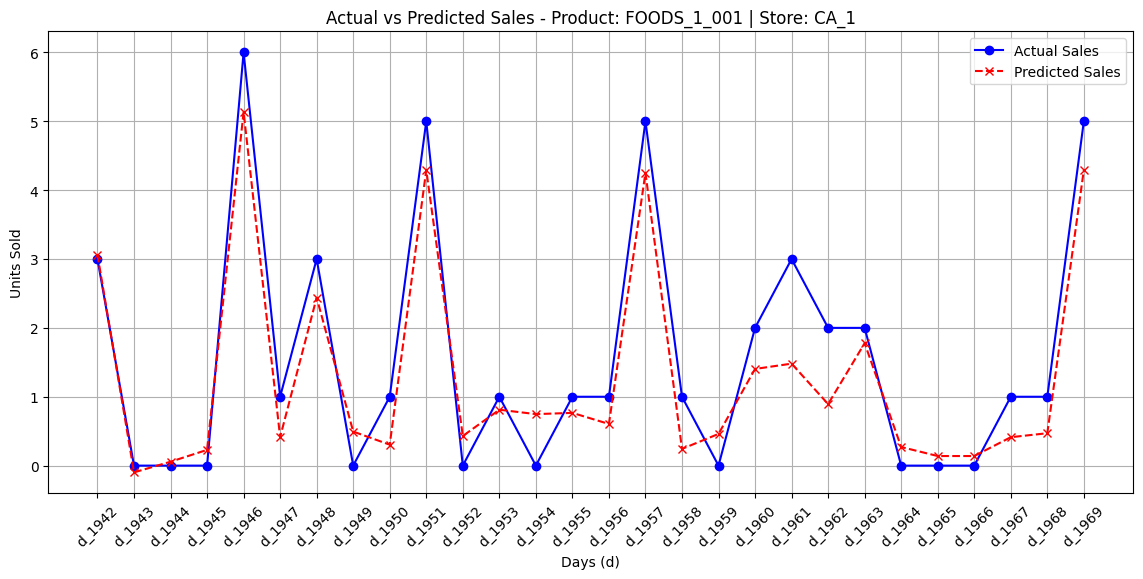

In [117]:
import matplotlib.pyplot as plt

# Select a specific item_id and store_id for analysis
item_id_to_plot = 'FOODS_1_001'  # Replace with the desired item
store_id_to_plot = 'CA_1'        # Replace with the desired store

# Filter the DataFrame for the chosen product and store
product_df = df_merged[(df_merged['item_id'] == item_id_to_plot) & (df_merged['store_id'] == store_id_to_plot)]

# Sort by 'd' to ensure the correct temporal sequence
product_df = product_df.sort_values('d')

# Plot actual vs predicted sales over time
plt.figure(figsize=(14, 6))
plt.plot(product_df['d'], product_df['y'], label='Actual Sales', marker='o', linestyle='-', color='blue')
plt.plot(product_df['d'], product_df['y_pred'], label='Predicted Sales', marker='x', linestyle='--', color='red')
plt.xlabel('Days (d)')
plt.ylabel('Units Sold')
plt.title(f'Actual vs Predicted Sales - Product: {item_id_to_plot} | Store: {store_id_to_plot}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [110]:
for d in prediction_days:
    scope = df_merged.copy()
    scope = scope[scope['d'] == d]
    mae = mean_absolute_error(scope['y'], scope['y_pred'])
    print(f'Mean Absolute Error (MAE) for {d}: {mae}')

Mean Absolute Error (MAE) for d_1942: 0.5326752066612244
Mean Absolute Error (MAE) for d_1943: 0.5266267657279968
Mean Absolute Error (MAE) for d_1944: 0.4438340365886688
Mean Absolute Error (MAE) for d_1945: 0.4737997055053711
Mean Absolute Error (MAE) for d_1946: 0.48121994733810425
Mean Absolute Error (MAE) for d_1947: 0.5361232757568359
Mean Absolute Error (MAE) for d_1948: 0.5511469841003418
Mean Absolute Error (MAE) for d_1949: 0.5516849756240845
Mean Absolute Error (MAE) for d_1950: 0.508784294128418
Mean Absolute Error (MAE) for d_1951: 0.48739469051361084
Mean Absolute Error (MAE) for d_1952: 0.5438247323036194
Mean Absolute Error (MAE) for d_1953: 0.5510283708572388
Mean Absolute Error (MAE) for d_1954: 0.6491951942443848
Mean Absolute Error (MAE) for d_1955: 0.6356231570243835
Mean Absolute Error (MAE) for d_1956: 0.6290174722671509
Mean Absolute Error (MAE) for d_1957: 0.5211808681488037
Mean Absolute Error (MAE) for d_1958: 0.48135069012641907
Mean Absolute Error (MAE) for

In [111]:
df_pivot = df_merged.pivot(index=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                    columns='d', 
                    values='y_pred').reset_index()
df_pivot.columns.name = None
df_pivot


,item_id,dept_id,cat_id,store_id,state_id,d_1942,d_1943,d_1944,d_1945,d_1946,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1.394928,0.290878,0.509379,0.474852,0.269501,...,0.222865,0.228588,1.277754,0.064679,0.062784,0.094307,0.118857,0.067959,2.028075,0.091722
1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,1.419803,0.189295,0.216781,0.217819,0.213293,...,0.210926,0.230528,0.247853,0.111486,0.001646,-0.028026,0.983456,0.023392,0.039443,0.063906
2,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,1.356188,1.291662,-0.026639,1.234509,0.112780,...,0.113307,1.110399,0.169172,1.121589,-0.005422,1.095146,0.026394,0.131292,1.179601,0.199064
3,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,0.157848,0.276003,2.359407,-0.069552,1.345902,...,1.088828,0.160032,0.227159,0.023687,1.083152,2.097674,-0.079887,1.138137,0.168631,0.171748
4,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,0.288194,2.323647,-0.006417,1.315996,0.027370,...,1.086718,-0.014396,0.121598,0.091639,-0.018201,2.097674,-0.088532,1.074943,0.137502,0.066200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_827,FOODS_3,FOODS,TX_2,TX,0.095995,0.075971,7.525940,-0.076010,-0.008181,...,2.300740,0.723324,2.513859,0.335016,0.496278,0.722219,1.542514,0.723077,0.424822,0.363952
30486,FOODS_3_827,FOODS_3,FOODS,TX_3,TX,0.702669,0.619503,0.562136,4.469003,0.063818,...,0.107851,0.793918,0.332709,2.576402,0.117118,3.403670,0.479234,2.454304,0.395481,0.628367
30487,FOODS_3_827,FOODS_3,FOODS,WI_1,WI,0.674868,1.597962,1.198853,1.121969,1.228863,...,1.106638,16.425585,1.629534,1.869971,1.848439,1.543604,1.811385,1.128628,1.272182,0.900473
30488,FOODS_3_827,FOODS_3,FOODS,WI_2,WI,0.957833,0.947219,0.867868,1.042814,3.145136,...,2.307583,1.241343,4.865969,0.338490,7.180743,1.062521,1.244104,1.380796,1.462373,1.329524


In [112]:
df_pivot.to_csv('../results/final_predictions.csv', index=False)